In [1]:
import numpy as np
import copy as copy
import netCDF4 as ncd
from sklearn.ensemble import RandomForestRegressor as rfr
import matplotlib.pyplot as plt
def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

In [2]:
d=ncd.Dataset("/Users/connorgod/Desktop/Tian Zheng/project/code_and_data/Data/training_data_for_SF_hbl_gaps_filled.nc").variables

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 

ind1=np.where(np.abs(heat0)<601)[0]
ind2=np.where(tx0<1.2)[0]
ind3=np.where(h0>29)[0]
ind4=np.where(h0<301)[0]

ind5=np.intersect1d(ind1,ind2)
ind6=np.intersect1d(ind3,ind5)
ind7=np.intersect1d(ind4,ind6)

mm1=0; mm2=16  #0; 16
data_load_main=np.zeros([len(h0[ind7]),4+mm2-mm1])
data_load_main[:,0]=l0[ind7]
data_load_main[:,1]=b00[ind7]
data_load_main[:,2]=ustar0[ind7]
data_load_main[:,3]=h0[ind7]
data_load_main[:,4:(mm2-mm1+4)]=SF0[ind7,mm1:mm2]

data_load3=copy.deepcopy(data_load_main)

In [3]:
def preprocess_train_data(data_load):


    ind=np.arange(0,len(data_load),1)    # creates a list of indices to shuffle
    ind_shuffle=copy.deepcopy(ind)  # deep copies the indices
    np.random.shuffle(ind_shuffle)  # shuffles the array
    
    l_mean=np.mean(data_load[:,0]); 
    l_std=np.std(data_load[:,0]); 
    data_load[:,0]=(data_load[:,0]-l_mean)/l_std    #l
    
    h_mean=np.mean(data_load[:,1]); 
    h_std=np.std(data_load[:,1]); 
    data_load[:,1]=(data_load[:,1]-h_mean)/h_std    #b0
    
    t_mean=np.mean(data_load[:,2]); 
    t_std=np.std(data_load[:,2]); 
    data_load[:,2]=(data_load[:,2]-t_mean)/t_std    #u*
    
    hb_mean= np.mean(data_load[:,3]); 
    hb_std=np.std(data_load[:,3]); 
    data_load[:,3]=(data_load[:,3]-hb_mean)/(hb_std)  #w*

    stats=np.array([l_mean, l_std, h_mean, h_std, t_mean, t_std, hb_mean, hb_std])
    tr_x=data_load[ind_shuffle,0:4]

    log_gsigma = data_load[:,4:]

    # Take the logarithm of normalized Kappa(sigma)
    for j in range(log_gsigma.shape[0]):
        log_gsigma[j,:] = np.log(log_gsigma[j,:]/np.max(log_gsigma[j,:]))

    log_gsigma_mean=np.mean(log_gsigma,axis=0)
    log_gsigma_std= np.std(log_gsigma,axis=0)

    k_points=16 #np.shape(data[:,4:])[1]

    # Demean logsigma and normalize it with standard deviation
    for k in range(k_points):
        log_gsigma[:,k]=(log_gsigma[:,k]-log_gsigma_mean[k])/log_gsigma_std[k]

    tr_y=log_gsigma
    
    return tr_x,tr_y, stats, log_gsigma_mean, log_gsigma_std

tr_x,tr_y, stats, log_gsigma_mean, log_gsigma_std=preprocess_train_data(data_load3)

In [4]:
valid_data=np.loadtxt('/Users/connorgod/Desktop/Tian Zheng/project/code_and_data/Data/data_testing_4_paper.txt')[:,3:]

ind3=np.where(valid_data[:,3]>29)[0]
ind4=np.where(valid_data[:,3]<301)[0]
ind=np.intersect1d(ind3,ind4)

valid_x=valid_data[ind,0:4]

valid_x[:,0]=(valid_x[:,0]-stats[0])/stats[1]
valid_x[:,1]=(valid_x[:,1]-stats[2])/stats[3]
valid_x[:,2]=(valid_x[:,2]-stats[4])/stats[5]
valid_x[:,3]=(valid_x[:,3]-stats[6])/stats[7]
valid_y=valid_data[ind,5:]

for i in range(len(valid_y)):
    valid_y[i,:]=np.log(valid_y[i,:]/np.max(valid_y[i,:]))

for i in range(16):
    valid_y[:,i]=(valid_y[:,i]-log_gsigma_mean[i])/log_gsigma_mean[i]

In [5]:
# Randomly select 1% of data 
np.random.seed(66)
tr_ind = np.arange(0,tr_x.shape[0],1)
np.random.shuffle(tr_ind) 
tr_num_selected = round(len(tr_ind)*0.01)
tr_x_sample = tr_x[tr_ind,:][:tr_num_selected,:]
tr_y_sample = tr_y[tr_ind,:][:tr_num_selected,:]
print(tr_x_sample.shape)
val_ind = np.arange(0,valid_x.shape[0],1)
np.random.shuffle(val_ind)
val_num_selected = round(len(val_ind)*0.01)
val_x_sample = valid_x[val_ind,:][:val_num_selected,:]
val_y_sample = valid_y[val_ind,:][:val_num_selected,:]
print(val_x_sample.shape)

(9179, 4)
(899, 4)


In [6]:
rfr = rfr(n_estimators=100,criterion="absolute_error",max_depth=1,max_features="sqrt",bootstrap=True,oob_score=True,
          n_jobs=3,random_state=66)
rfr.fit(tr_x_sample,tr_y_sample)

RandomForestRegressor(criterion='absolute_error', max_depth=1,
                      max_features='sqrt', n_jobs=3, oob_score=True,
                      random_state=66)

In [8]:
rfr.oob_score_

-0.07417833959140267

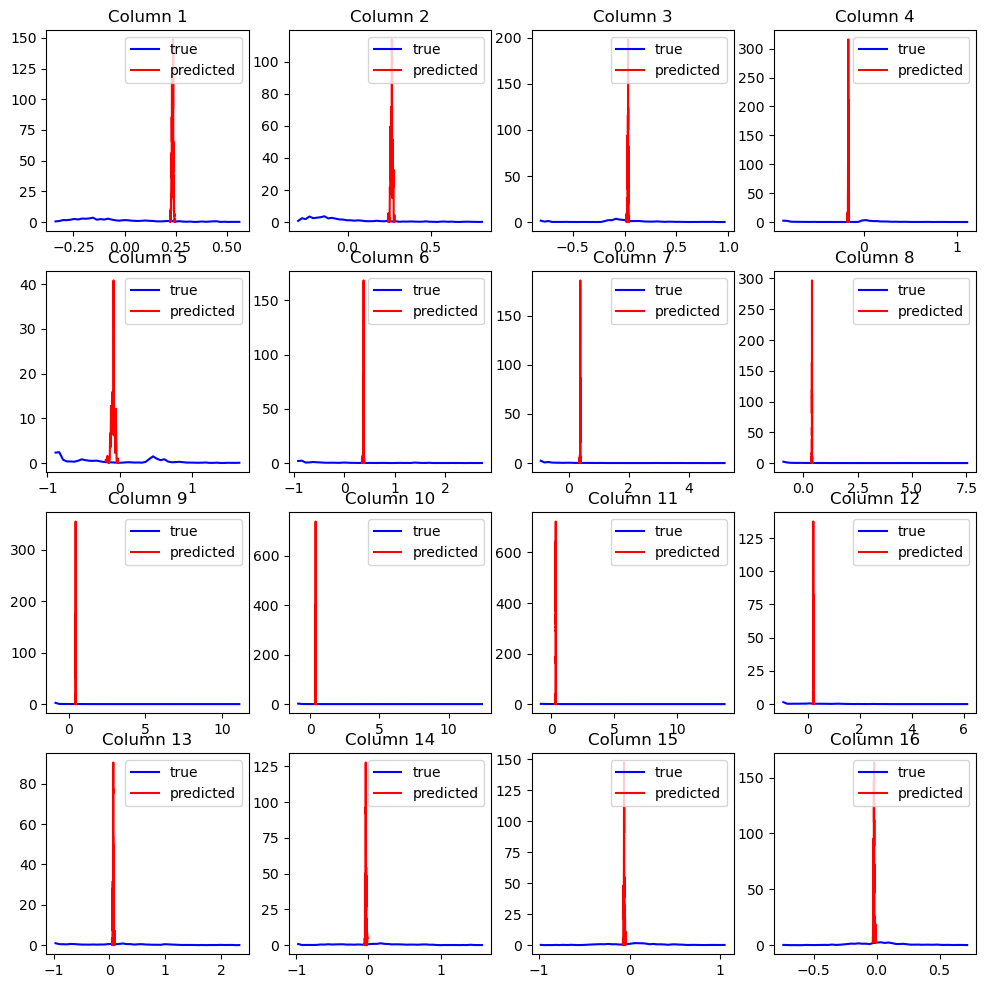

In [31]:
pred_val_y_sample = rfr.predict(val_x_sample)

dist_fig, dist_axes = plt.subplots(nrows = 4, ncols = 4, figsize = (12,12))

for i, ax in enumerate(dist_axes.flat):
    true = val_y_sample[:,i].flatten()
    true_counts, true_bin_edges = np.histogram(true, bins=50, density=True)
    true_bin_centers = (true_bin_edges[:-1]+true_bin_edges[1:])/2
    ax.plot(true_bin_centers,true_counts,color="blue",label = "true")

    pred = pred_val_y_sample[:,i].flatten()
    pred_counts, pred_bin_edges = np.histogram(pred, bins=50, density=True)
    pred_bin_centers = (pred_bin_edges[:-1]+pred_bin_edges[1:])/2
    ax.plot(pred_bin_centers,pred_counts,color="red",label = "predicted")

    ax.legend(loc = "upper right")
    ax.set_title(f"Column {i+1}")

In [ ]:
# That may be due to inadequate data points.